# Load Data and Package

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress, kstest, cramervonmises, anderson_ksamp
from scipy.optimize import minimize

In [10]:
df = pd.read_csv('M7 Declustering.csv')

# Gutenberg Richter Fit

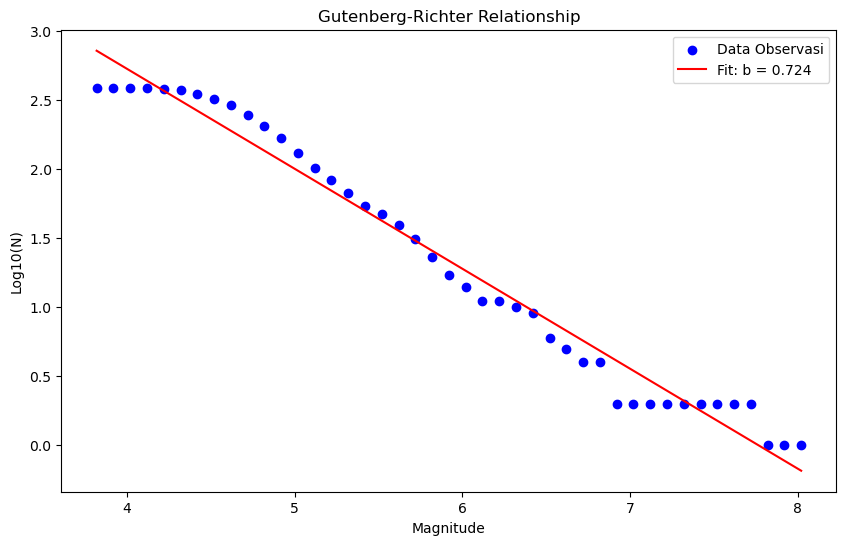

b-value: 0.724, a-value: 5.621, R^2: 0.977


In [11]:
# Data magnitudo
magnitude = df['mag']

# Histogram kumulatif
min_mag, max_mag = magnitude.min(), magnitude.max()
bins = np.arange(min_mag, max_mag + 0.1, 0.1)
hist, edges = np.histogram(magnitude, bins=bins)
cum_hist = np.cumsum(hist[::-1])[::-1]

# Log N dan Magnitudo
log_cum_hist = np.log10(cum_hist[cum_hist > 0])
mags = edges[:-1][cum_hist > 0]

# Regresi Linear
slope, intercept, r_value, _, _ = linregress(mags, log_cum_hist)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(mags, log_cum_hist, label='Data Observasi', color='blue')
plt.plot(mags, slope * mags + intercept, label=f'Fit: b = {-slope:.3f}', color='red')
plt.xlabel('Magnitude')
plt.ylabel('Log10(N)')
plt.title('Gutenberg-Richter Relationship')
plt.legend()
plt.show()

print(f"b-value: {-slope:.3f}, a-value: {intercept:.3f}, R^2: {r_value**2:.3f}")

Magnitude of Completeness (Mc): 4.61969


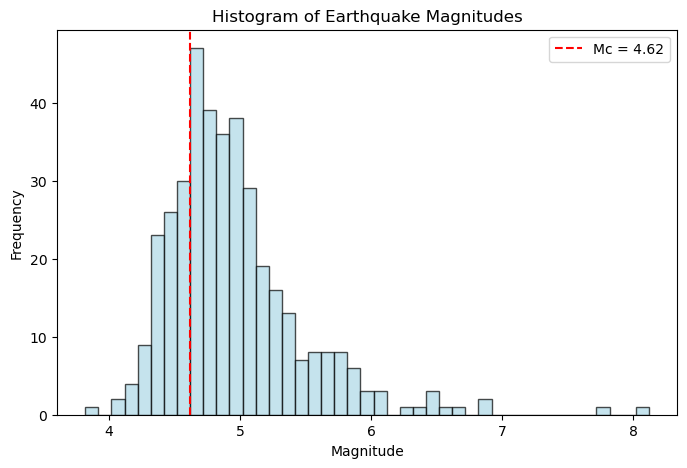

In [12]:
# Filter data berdasarkan magnitudo (pastikan kolom magnitude sesuai nama di dataset)
magnitudes = magnitude

# Membuat histogram magnitudo
bin_width = 0.1
bins = np.arange(magnitudes.min(), magnitudes.max() + bin_width, bin_width)
hist, bin_edges = np.histogram(magnitudes, bins=bins)

# Menentukan Mc (Magnitude of Completeness)
Mc_index = np.argmax(hist)  # Indeks bin dengan jumlah maksimum
Mc = bin_edges[Mc_index]

print(f"Magnitude of Completeness (Mc): {Mc}")

# Plot histogram untuk visualisasi Mc
plt.figure(figsize=(8, 5))
plt.hist(magnitudes, bins=bins, color='lightblue', edgecolor='black', alpha=0.7)
plt.axvline(Mc, color='red', linestyle='--', label=f'Mc = {Mc:.2f}')
plt.xlabel('Magnitude')
plt.ylabel('Frequency')
plt.title('Histogram of Earthquake Magnitudes')
plt.legend()
plt.show()

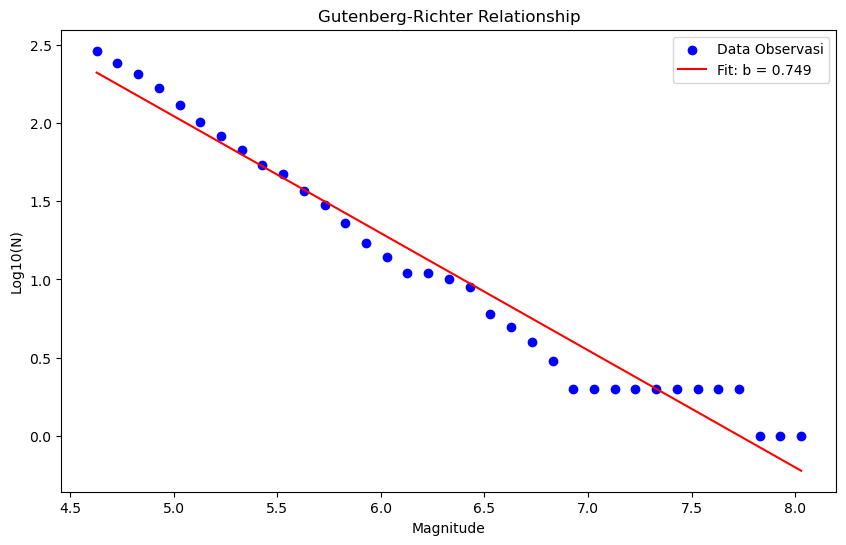

b-value: 0.749, a-value: 5.793, R^2: 0.968


In [13]:
# Data magnitudo
magnitude = df[df['mag'] >= Mc]['mag']  # Filter data dengan magnitudo >= 4.62

# Histogram kumulatif
min_mag, max_mag = magnitude.min(), magnitude.max()
bins = np.arange(min_mag, max_mag + 0.1, 0.1)
hist, edges = np.histogram(magnitude, bins=bins)
cum_hist = np.cumsum(hist[::-1])[::-1]

# Log N dan Magnitudo
log_cum_hist = np.log10(cum_hist[cum_hist > 0])
mags = edges[:-1][cum_hist > 0]

# Regresi Linear
from scipy.stats import linregress
slope, intercept, r_value, _, _ = linregress(mags, log_cum_hist)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(mags, log_cum_hist, label='Data Observasi', color='blue')
plt.plot(mags, slope * mags + intercept, label=f'Fit: b = {-slope:.3f}', color='red')
plt.xlabel('Magnitude')
plt.ylabel('Log10(N)')
plt.title('Gutenberg-Richter Relationship')
plt.legend()
plt.show()

print(f"b-value: {-slope:.3f}, a-value: {intercept:.3f}, R^2: {r_value**2:.3f}")

# Gutenberg Richter-GPD

Estimasi Parameter GR-GPD
b value = 0.7495
beta = 1.7257
u = 5.65
xi = -0.1826
sigma = 0.3940


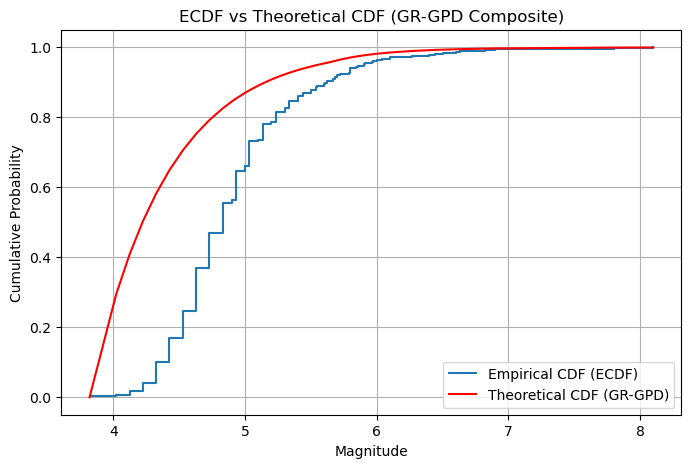


Statistik Model
Statistik KS = 0.5478
P-value KS = 0.0000
Statistik AD = 407.1029
P-value AD = 0.0000
Statistik CvM = 45.4930
P-value CvM = 0.0000
AIC = 6134.4054
BIC = 6142.3170


C:\Users\user\AppData\Local\Temp\ipykernel_3088\1514891163.py:89: UserWarning: p-value floored: true value smaller than 0.001
  ad_result = anderson_ksamp([x, theoretical_cdf])


In [14]:
def estimate_gr_gpd(df, Mc, u=5.65):
    # Gunakan hanya data dengan magnitude >= Mc untuk GR fit
    mag_gr = df[df['mag'] >= Mc]['mag'].values

    # Gutenberg-Richter fit untuk b-value
    min_mag, max_mag = mag_gr.min(), mag_gr.max()
    bins = np.arange(min_mag, max_mag + 0.1, 0.1)
    hist, edges = np.histogram(mag_gr, bins=bins)
    cum_hist = np.cumsum(hist[::-1])[::-1]
    log_cum_hist = np.log10(cum_hist[cum_hist > 0])
    mags = edges[:-1][cum_hist > 0]
    from scipy.stats import linregress
    slope, intercept, r_value, _, _ = linregress(mags, log_cum_hist)
    b_value = -slope
    beta = b_value * np.log(10)

    # Estimasi parameter GR-GPD pada seluruh data
    x = df['mag'].values
    above = x[x >= u]
    sigma0 = np.std(above - u) if len(above) > 0 else 1.0
    xi0 = 0.1

    def gr_gpd_loglik(params, x, u, beta):
        xi, sigma = params
        if sigma <= 0:
            return np.inf
        below = x[x < u]
        above = x[x >= u]
        ll_gr = np.sum(np.log(beta) - beta * below)
        y = above - u
        if np.abs(xi) > 1e-6:
            gpd = (1/sigma) * (1 - xi * y / sigma) ** (1/xi - 1)
            gpd = np.where((1 - xi * y / sigma) > 0, gpd, 1e-12)
        else:
            gpd = (1/sigma) * np.exp(-y/sigma)
        ll_gpd = np.sum(-beta * u + np.log(gpd))
        return -(ll_gr + ll_gpd)

    def gr_gpd_cdf(val, b, u, xi, sigma):
        beta = b * np.log(10)
        val = np.asarray(val)
        cdf = np.zeros_like(val)
        mask_below = val < u
        mask_above = val >= u
        cdf[mask_below] = 1 - np.exp(-beta * (val[mask_below] - val.min()))
        if np.abs(xi) > 1e-6:
            G = 1 - (1 - xi * (val[mask_above] - u) / sigma) ** (1/xi)
        else:
            G = 1 - np.exp(-(val[mask_above] - u) / sigma)
        H_u = 1 - np.exp(-beta * (u - val.min()))
        cdf[mask_above] = H_u + (1 - H_u) * G
        return cdf

    from scipy.optimize import minimize
    res = minimize(
        gr_gpd_loglik,
        x0=[xi0, sigma0],
        args=(x, u, beta),
        bounds=[(-1, 1), (1e-6, None)],
        method='L-BFGS-B'
    )
    xi_hat, sigma_hat = res.x

    print("Estimasi Parameter GR-GPD")
    print(f"b value = {b_value:.4f}")
    print(f"beta = {beta:.4f}")
    print(f"u = {u:.2f}")
    print(f"xi = {xi_hat:.4f}")
    print(f"sigma = {sigma_hat:.4f}")

    # ECDF vs Theoretical CDF
    mag_sorted = np.sort(x)
    ecdf = np.arange(1, len(mag_sorted)+1) / len(mag_sorted)
    theoretical_cdf = gr_gpd_cdf(mag_sorted, b_value, u, xi_hat, sigma_hat)

    plt.figure(figsize=(8,5))
    plt.step(mag_sorted, ecdf, where='post', label='Empirical CDF (ECDF)')
    plt.plot(mag_sorted, theoretical_cdf, 'r-', label='Theoretical CDF (GR-GPD)')
    plt.xlabel('Magnitude')
    plt.ylabel('Cumulative Probability')
    plt.title('ECDF vs Theoretical CDF (GR-GPD Composite)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Goodness-of-fit
    from scipy.stats import kstest, cramervonmises, anderson_ksamp
    ks_stat, ks_p = kstest(x, lambda v: gr_gpd_cdf(v, b_value, u, xi_hat, sigma_hat))
    ad_result = anderson_ksamp([x, theoretical_cdf])
    ad_stat = ad_result.statistic
    ad_p = ad_result.significance_level / 100
    cvm_result = cramervonmises(x, lambda v: gr_gpd_cdf(v, b_value, u, xi_hat, sigma_hat))
    cvm_stat = cvm_result.statistic
    cvm_p = cvm_result.pvalue

    # Log-likelihood, AIC, BIC
    ll = -gr_gpd_loglik([xi_hat, sigma_hat], x, u, beta)
    k = 2  # xi, sigma
    n = len(x)
    aic = 2 * k - 2 * ll
    bic = k * np.log(n) - 2 * ll

    print("\nStatistik Model")
    print(f"Statistik KS = {ks_stat:.4f}")
    print(f"P-value KS = {ks_p:.4f}")
    print(f"Statistik AD = {ad_stat:.4f}")
    print(f"P-value AD = {ad_p:.4f}")
    print(f"Statistik CvM = {cvm_stat:.4f}")
    print(f"P-value CvM = {cvm_p:.4f}")
    print(f"AIC = {aic:.4f}")
    print(f"BIC = {bic:.4f}")

# Contoh pemanggilan:
estimate_gr_gpd(df, Mc, u=5.65)

# Choosing the Threshold

In [15]:
percentiles = [85, 90, 92.5, 95, 97.5]
thresholds = [np.percentile(df['mag'], p) for p in percentiles]

results = []

for u in thresholds:
    # Estimasi parameter dan statistik model
    x = df['mag'].values
    mag_gr = df[df['mag'] >= Mc]['mag'].values
    min_mag, max_mag = mag_gr.min(), mag_gr.max()
    bins = np.arange(min_mag, max_mag + 0.1, 0.1)
    hist, edges = np.histogram(mag_gr, bins=bins)
    cum_hist = np.cumsum(hist[::-1])[::-1]
    log_cum_hist = np.log10(cum_hist[cum_hist > 0])
    mags = edges[:-1][cum_hist > 0]
    slope, intercept, r_value, _, _ = linregress(mags, log_cum_hist)
    b_value = -slope
    beta = b_value * np.log(10)
    above = x[x >= u]
    sigma0 = np.std(above - u) if len(above) > 0 else 1.0
    xi0 = 0.1

    def gr_gpd_loglik(params, x, u, beta):
        xi, sigma = params
        if sigma <= 0:
            return np.inf
        below = x[x < u]
        above = x[x >= u]
        ll_gr = np.sum(np.log(beta) - beta * below)
        y = above - u
        if np.abs(xi) > 1e-6:
            gpd = (1/sigma) * (1 - xi * y / sigma) ** (1/xi - 1)
            gpd = np.where((1 - xi * y / sigma) > 0, gpd, 1e-12)
        else:
            gpd = (1/sigma) * np.exp(-y/sigma)
        ll_gpd = np.sum(-beta * u + np.log(gpd))
        return -(ll_gr + ll_gpd)

    def gr_gpd_cdf(val, b, u, xi, sigma):
        beta = b * np.log(10)
        val = np.asarray(val)
        cdf = np.zeros_like(val)
        mask_below = val < u
        mask_above = val >= u
        cdf[mask_below] = 1 - np.exp(-beta * (val[mask_below] - val.min()))
        if np.abs(xi) > 1e-6:
            G = 1 - (1 - xi * (val[mask_above] - u) / sigma) ** (1/xi)
        else:
            G = 1 - np.exp(-(val[mask_above] - u) / sigma)
        H_u = 1 - np.exp(-beta * (u - val.min()))
        cdf[mask_above] = H_u + (1 - H_u) * G
        return cdf

    res = minimize(
        gr_gpd_loglik,
        x0=[xi0, sigma0],
        args=(x, u, beta),
        bounds=[(-1, 1), (1e-6, None)],
        method='L-BFGS-B'
    )
    xi_hat, sigma_hat = res.x

    # Goodness-of-fit
    ks_stat, ks_p = kstest(x, lambda v: gr_gpd_cdf(v, b_value, u, xi_hat, sigma_hat))
    ad_result = anderson_ksamp([x, gr_gpd_cdf(x, b_value, u, xi_hat, sigma_hat)])
    ad_stat = ad_result.statistic
    ad_p = ad_result.significance_level / 100
    cvm_result = cramervonmises(x, lambda v: gr_gpd_cdf(v, b_value, u, xi_hat, sigma_hat))
    cvm_stat = cvm_result.statistic
    cvm_p = cvm_result.pvalue

    # Log-likelihood, AIC, BIC
    ll = -gr_gpd_loglik([xi_hat, sigma_hat], x, u, beta)
    k = 2
    n = len(x)
    aic = 2 * k - 2 * ll
    bic = k * np.log(n) - 2 * ll

    results.append({
        "Threshold": u,
        "Statistik KS": ks_stat,
        "P-value KS": ks_p,
        "Statistik AD": ad_stat,
        "P-value AD": ad_p,
        "Statistik CvM": cvm_stat,
        "P-value CvM": cvm_p,
        "AIC": aic,
        "BIC": bic
    })

import pandas as pd
results_df = pd.DataFrame(results)
print("Hasil Fitting GR-GPD untuk Berbagai Threshold:")
print(results_df.to_string(index=False))

# Pemilihan threshold terbaik
idx_ks_min = results_df['Statistik KS'].idxmin()
idx_ks_p_max = results_df['P-value KS'].idxmax()
idx_ad_min = results_df['Statistik AD'].idxmin()
idx_ad_p_max = results_df['P-value AD'].idxmax()
idx_cvm_min = results_df['Statistik CvM'].idxmin()
idx_cvm_p_max = results_df['P-value CvM'].idxmax()
idx_aic_min = results_df['AIC'].idxmin()
idx_bic_min = results_df['BIC'].idxmin()

print("\nPemilihan Threshold (angka threshold):")
print(f"Statistik KS terkecil = {results_df.loc[idx_ks_min, 'Threshold']:.3f}")
print(f"P-value KS terbesar = {results_df.loc[idx_ks_p_max, 'Threshold']:.3f}")
print(f"Statistik AD terkecil = {results_df.loc[idx_ad_min, 'Threshold']:.3f}")
print(f"P-value AD terbesar = {results_df.loc[idx_ad_p_max, 'Threshold']:.3f}")
print(f"Statistik CvM terkecil = {results_df.loc[idx_cvm_min, 'Threshold']:.3f}")
print(f"P-value CvM terbesar = {results_df.loc[idx_cvm_p_max, 'Threshold']:.3f}")
print(f"AIC terkecil = {results_df.loc[idx_aic_min, 'Threshold']:.3f}")
print(f"BIC terkecil = {results_df.loc[idx_bic_min, 'Threshold']:.3f}")

Hasil Fitting GR-GPD untuk Berbagai Threshold:
 Threshold  Statistik KS    P-value KS  Statistik AD  P-value AD  Statistik CvM  P-value CvM         AIC         BIC
   5.40000      0.547797 3.194931e-109    407.102912     0.00001      45.502033 1.301966e-08 6134.971544 6142.883219
   5.61216      0.547797 3.194931e-109    407.102912     0.00001      45.493044 1.298117e-08 6135.019312 6142.930987
   5.77250      0.547797 3.194931e-109    407.102912     0.00001      45.490686 1.297109e-08 6134.000826 6141.912501
   5.90000      0.547797 3.194931e-109    407.102912     0.00001      45.488620 1.296227e-08 6135.598565 6143.510239
   6.31875      0.547797 3.194931e-109    407.102912     0.00001      45.487942 1.295938e-08 6136.541727 6144.453402

Pemilihan Threshold (angka threshold):
Statistik KS terkecil = 5.400
P-value KS terbesar = 5.400
Statistik AD terkecil = 5.400
P-value AD terbesar = 5.400
Statistik CvM terkecil = 6.319
P-value CvM terbesar = 5.400
AIC terkecil = 5.772
BIC terkecil =

C:\Users\user\AppData\Local\Temp\ipykernel_3088\3863878804.py:65: UserWarning: p-value floored: true value smaller than 0.001
  ad_result = anderson_ksamp([x, gr_gpd_cdf(x, b_value, u, xi_hat, sigma_hat)])


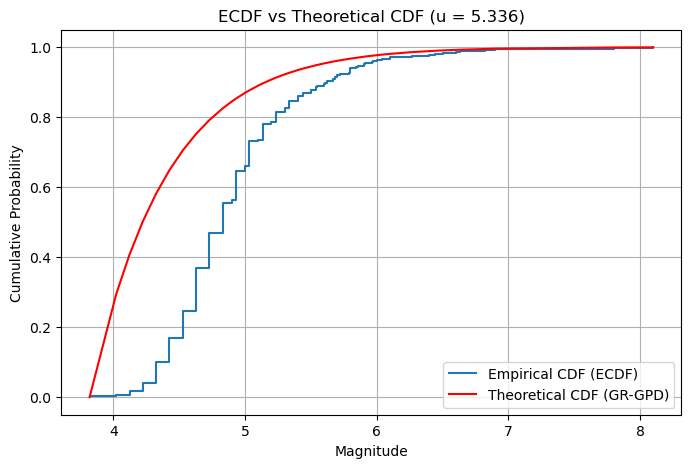

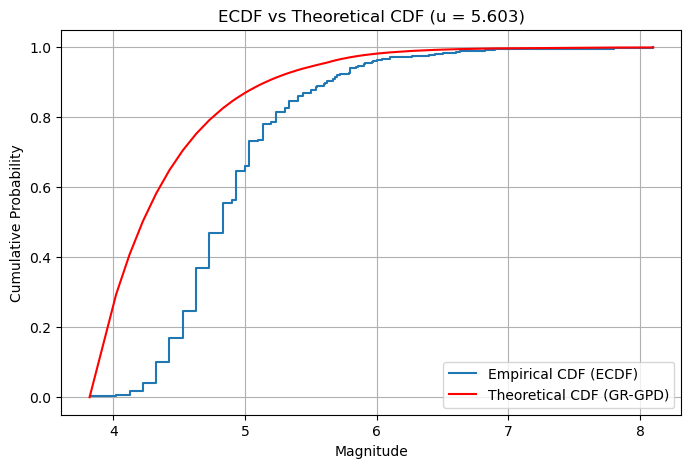

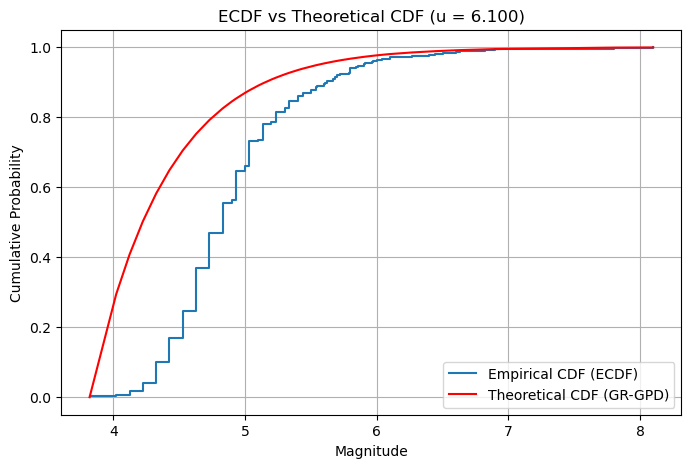

In [16]:
# Threshold kandidat
thresholds = [5.336, 5.603, 6.1]

for u in thresholds:
    # Estimasi b-value dari GR fit dengan Mc (sudah dihitung sebelumnya)
    mag_gr = df[df['mag'] >= Mc]['mag'].values
    min_mag, max_mag = mag_gr.min(), mag_gr.max()
    bins = np.arange(min_mag, max_mag + 0.1, 0.1)
    hist, edges = np.histogram(mag_gr, bins=bins)
    cum_hist = np.cumsum(hist[::-1])[::-1]
    log_cum_hist = np.log10(cum_hist[cum_hist > 0])
    mags = edges[:-1][cum_hist > 0]
    slope, intercept, r_value, _, _ = linregress(mags, log_cum_hist)
    b_value = -slope

    # Estimasi parameter GR-GPD untuk threshold u
    x = df['mag'].values
    above = x[x >= u]
    sigma0 = np.std(above - u) if len(above) > 0 else 1.0
    xi0 = 0.1
    beta = b_value * np.log(10)

    def gr_gpd_loglik(params, x, u, beta):
        xi, sigma = params
        if sigma <= 0:
            return np.inf
        below = x[x < u]
        above = x[x >= u]
        ll_gr = np.sum(np.log(beta) - beta * below)
        y = above - u
        if np.abs(xi) > 1e-6:
            gpd = (1/sigma) * (1 - xi * y / sigma) ** (1/xi - 1)
            gpd = np.where((1 - xi * y / sigma) > 0, gpd, 1e-12)
        else:
            gpd = (1/sigma) * np.exp(-y/sigma)
        ll_gpd = np.sum(-beta * u + np.log(gpd))
        return -(ll_gr + ll_gpd)

    def gr_gpd_cdf(val, b, u, xi, sigma):
        beta = b * np.log(10)
        val = np.asarray(val)
        cdf = np.zeros_like(val)
        mask_below = val < u
        mask_above = val >= u
        cdf[mask_below] = 1 - np.exp(-beta * (val[mask_below] - val.min()))
        if np.abs(xi) > 1e-6:
            G = 1 - (1 - xi * (val[mask_above] - u) / sigma) ** (1/xi)
        else:
            G = 1 - np.exp(-(val[mask_above] - u) / sigma)
        H_u = 1 - np.exp(-beta * (u - val.min()))
        cdf[mask_above] = H_u + (1 - H_u) * G
        return cdf

    res = minimize(
        gr_gpd_loglik,
        x0=[xi0, sigma0],
        args=(x, u, beta),
        bounds=[(-1, 1), (1e-6, None)],
        method='L-BFGS-B'
    )
    xi_hat, sigma_hat = res.x

    # Plot ECDF vs Theoretical CDF
    mag_sorted = np.sort(x)
    ecdf = np.arange(1, len(mag_sorted)+1) / len(mag_sorted)
    theoretical_cdf = gr_gpd_cdf(mag_sorted, b_value, u, xi_hat, sigma_hat)

    plt.figure(figsize=(8,5))
    plt.step(mag_sorted, ecdf, where='post', label='Empirical CDF (ECDF)')
    plt.plot(mag_sorted, theoretical_cdf, 'r-', label='Theoretical CDF (GR-GPD)')
    plt.xlabel('Magnitude')
    plt.ylabel('Cumulative Probability')
    plt.title(f'ECDF vs Theoretical CDF (u = {u:.3f})')
    plt.legend()
    plt.grid(True)
    plt.show()